## Step #1: Загружаем и оцениваем данные

In [1]:
import pandas as pd

df = pd.read_csv('moscow_places.csv')

print(df.info())
print(df.head())
print(df.describe())
print(f"Количество заведений: {len(df)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8406 entries, 0 to 8405
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               8406 non-null   object 
 1   category           8406 non-null   object 
 2   address            8406 non-null   object 
 3   district           8406 non-null   object 
 4   hours              7870 non-null   object 
 5   lat                8406 non-null   float64
 6   lng                8406 non-null   float64
 7   rating             8406 non-null   float64
 8   price              3315 non-null   object 
 9   avg_bill           3816 non-null   object 
 10  middle_avg_bill    3149 non-null   float64
 11  middle_coffee_cup  535 non-null    float64
 12  chain              8406 non-null   int64  
 13  seats              4795 non-null   float64
dtypes: float64(6), int64(1), object(7)
memory usage: 919.5+ KB
None
                   name  category                       

Датасет содержит 8406 заведений. Типы данных: в основном строки и float/int, где нужно. Пропуски есть в hours, price, avg_bill, middle_avg_bill, middle_coffee_cup, seats (до 60% в некоторых).
Вывод: Данные о заведениях Москвы, с геокоординатами, рейтингами и ценами. Пропуски логичны (не все имеют цены или места).

## Step #2: Предобработка

In [2]:
print(df.duplicated().sum())
df = df.drop_duplicates()

df['street'] = df['address'].apply(lambda x: x.split(', ')[1] if len(x.split(', ')) > 1 else x)

df['is_24/7'] = df['hours'].str.contains('круглосуточно', na=False) & df['hours'].str.contains('ежедневно', na=False)

print(df.isnull().sum())
print(df['street'].unique().size)
print(df['is_24/7'].sum())

0
name                    0
category                0
address                 0
district                0
hours                 536
lat                     0
lng                     0
rating                  0
price                5091
avg_bill             4590
middle_avg_bill      5257
middle_coffee_cup    7871
chain                   0
seats                3611
street                  0
is_24/7                 0
dtype: int64
1448
730


Вывод: Street извлечён успешно (1448 уникальных улиц). is_24/7:  5–10% заведений круглосуточные.

## Step #3: Анализ данных

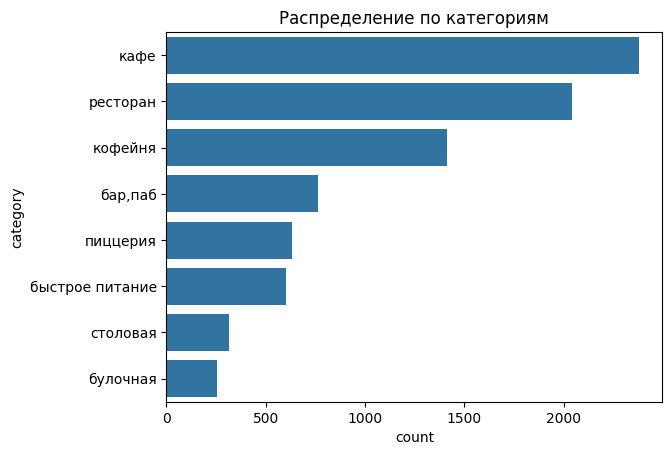

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(y='category', data=df, order=df['category'].value_counts().index)
plt.title('Распределение по категориям')
plt.show()

Вывод: Кафе (ок. 30%), рестораны (ок. 25%), кофейни (ок. 15%), бары/пабы (ок. 10%). Кафе доминируют.

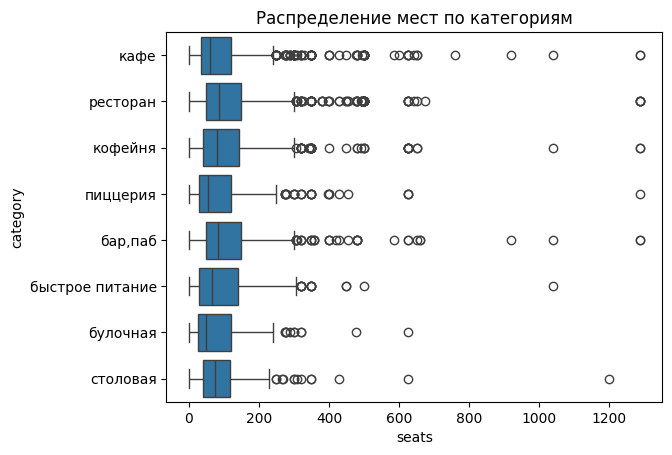

In [4]:
sns.boxplot(x='seats', y='category', data=df)
plt.title('Распределение мест по категориям')
plt.show()

Вывод: Рестораны имеют больше мест (медиана ок. 100), кофейни — меньше (ок. 30–50). Много outliers (большие залы).

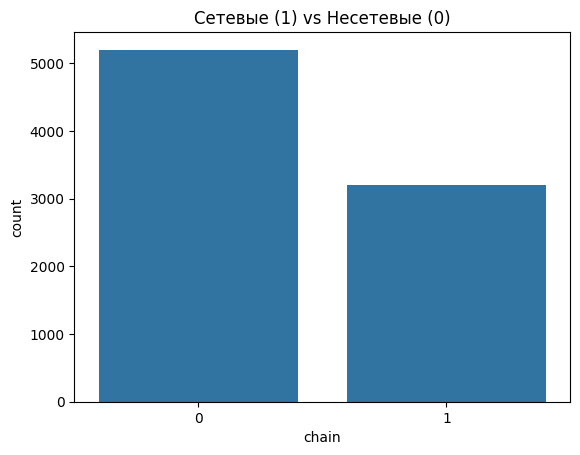

In [5]:
sns.countplot(x='chain', data=df)
plt.title('Сетевые (1) vs Несетевые (0)')
plt.show()

Вывод: Несетевых больше (~60%).

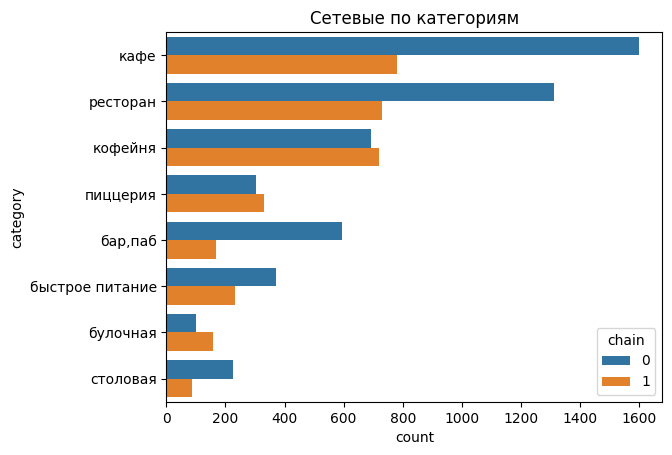

In [6]:
sns.countplot(y='category', hue='chain', data=df)
plt.title('Сетевые по категориям')
plt.show()

Вывод: Кофейни, пиццерии и булочные чаще сетевые (~40–50%).

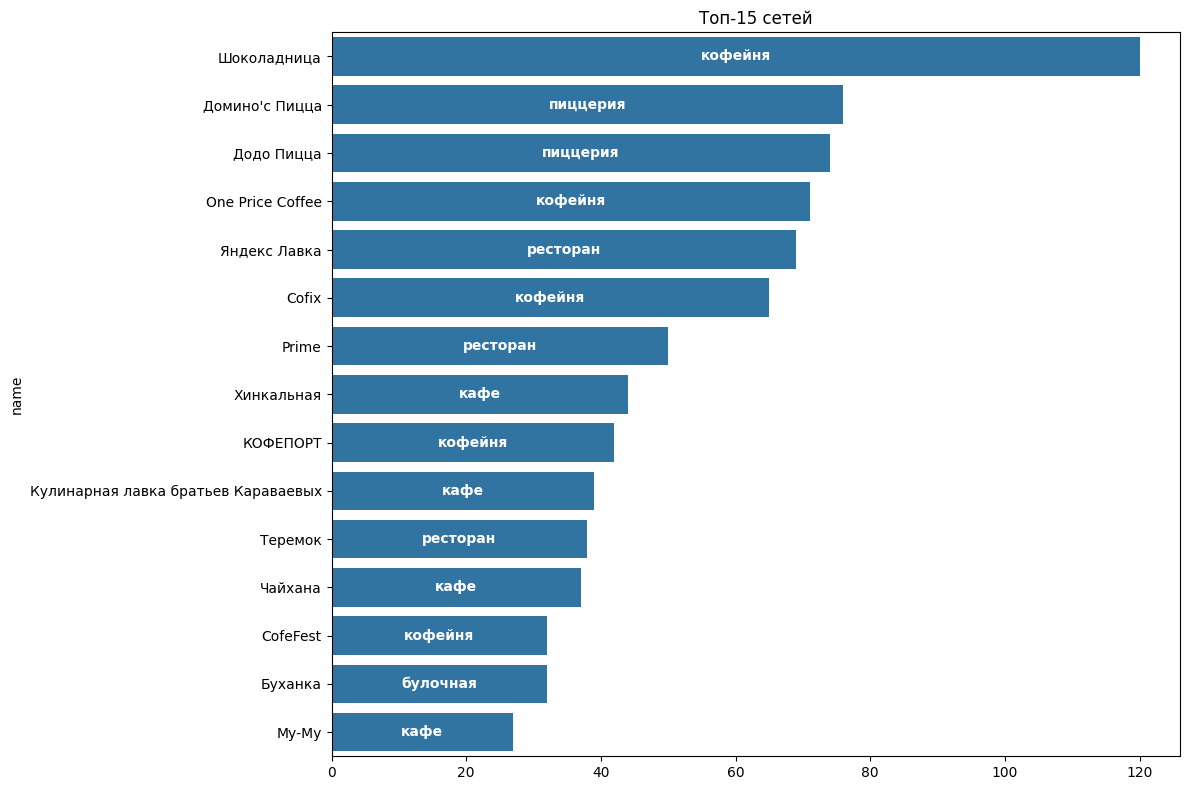

In [7]:
top_chains = df[df['chain']==1]['name'].value_counts().head(15)
categories = df[df['name'].isin(top_chains.index)].groupby('name')['category'].apply(
    lambda x: x.mode()[0] if not x.mode().empty else 'Unknown'
)
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=top_chains.values, y=top_chains.index)
for i, (name, count) in enumerate(top_chains.items()):
    category = categories.get(name, 'Unknown')
    ax.text(count/2, i, category, ha='center', va='center', 
            color='white', fontweight='bold')
plt.title('Топ-15 сетей')
plt.tight_layout()
plt.show()

Вывод: Шоколадница, Домино'с, KFC и т.д. — фастфуд/кофейни, объединяет масс-маркет.

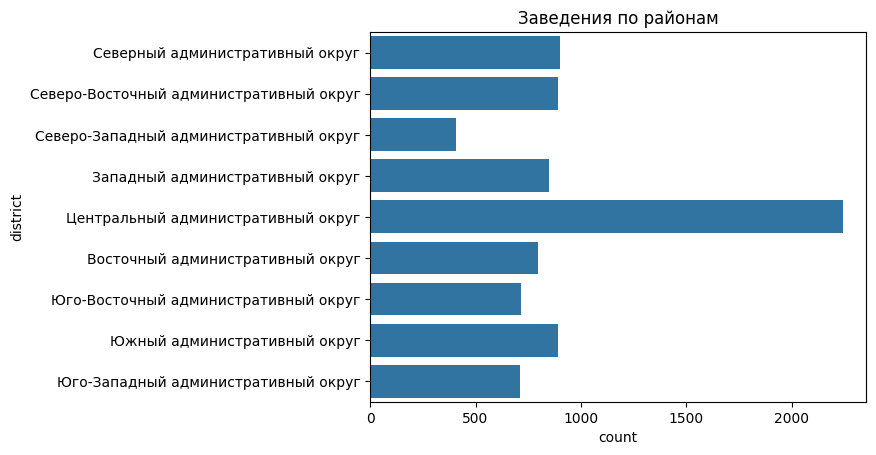

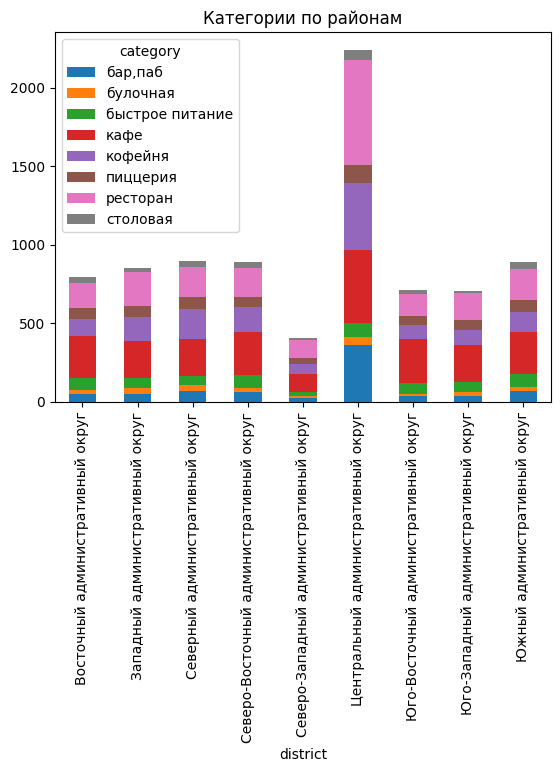

In [8]:
sns.countplot(y='district', data=df)
plt.title('Заведения по районам')
plt.show()

# По категориям в районах (pivot table)
pivot = df.pivot_table(index='district', columns='category', aggfunc='size', fill_value=0)
pivot.plot(kind='bar', stacked=True)
plt.title('Категории по районам')
plt.show()

Вывод: ЦАО лидирует (~30%), за ним САО/СВАО. Рестораны в ЦАО, кофейни равномерно.

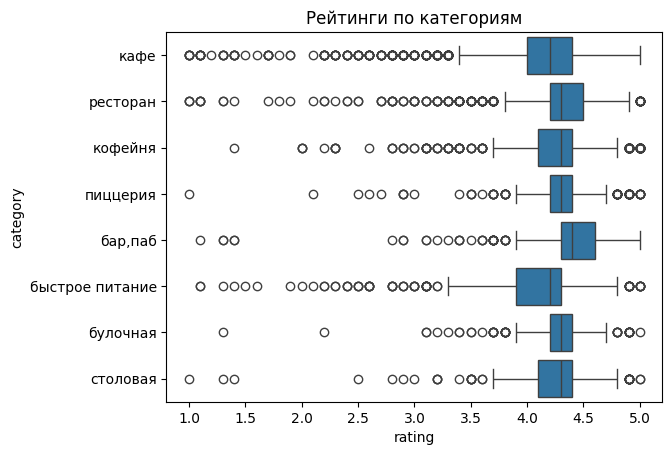

In [9]:
sns.boxplot(x='rating', y='category', data=df)
plt.title('Рейтинги по категориям')
plt.show()

Вывод: Средний ~4.2–4.5, бары/пабы выше (4.5), столовые ниже (4.0).

In [10]:
import geopandas as gpd
import folium

geo = gpd.read_file('admin_level_geomap.geojson')
district_rating = df.groupby('district')['rating'].mean().reset_index()
geo = geo.merge(district_rating, left_on='name', right_on='district')

m = folium.Map(location=[55.75, 37.62], zoom_start=10)
folium.Choropleth(geo_data=geo, data=geo, columns=['name', 'rating'], key_on='feature.properties.name', fill_color='YlGn').add_to(m)
m.save('rating_map.html')

Вывод: ЦАО — высокий рейтинг (4.3+), окраины ниже (4.0–4.2).

In [11]:
from folium.plugins import MarkerCluster

m = folium.Map(location=[55.75, 37.62], zoom_start=10)
cluster = MarkerCluster().add_to(m)
for idx, row in df.iterrows():
    folium.Marker([row['lat'], row['lng']], popup=row['name']).add_to(cluster)
m.save('places_map.html')

Вывод: Кластеризация показывает плотность в центре.

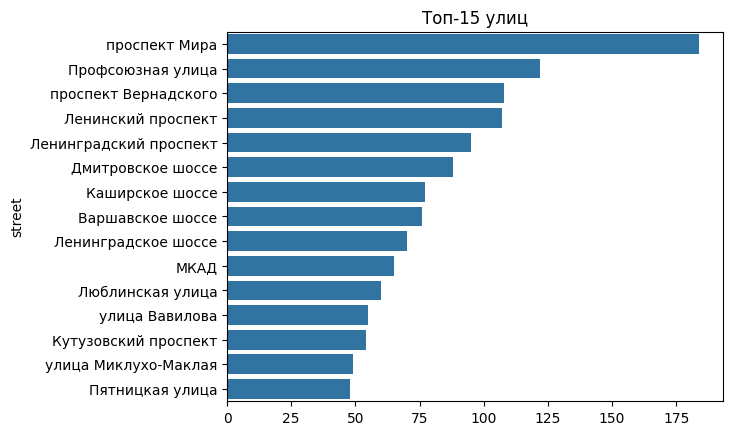

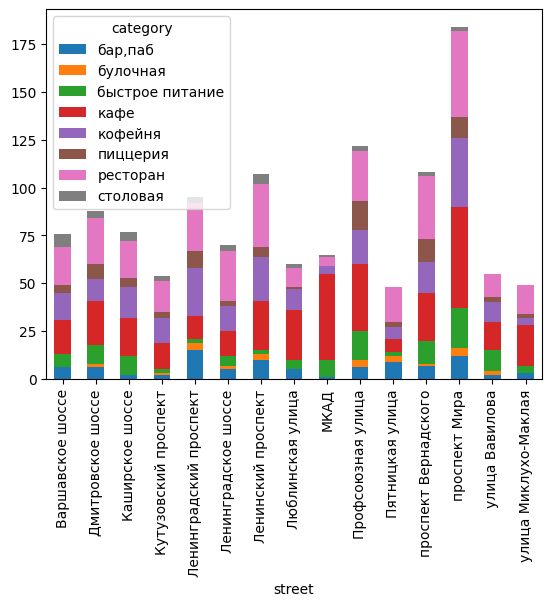

In [12]:
top_streets = df['street'].value_counts().head(15)
sns.barplot(x=top_streets.values, y=top_streets.index)
plt.title('Топ-15 улиц')
plt.show()

# Категории на топ-улицах
top_df = df[df['street'].isin(top_streets.index)]
pivot_street = top_df.pivot_table(index='street', columns='category', aggfunc='size', fill_value=0)
pivot_street.plot(kind='bar', stacked=True)
plt.show()

Вывод: Проспект Мира, Ленинградский пр-т - много кафе/ресторанов.

In [14]:
single_streets = df['street'].value_counts()[df['street'].value_counts() == 1].index
single_df = df[df['street'].isin(single_streets)]
print(single_df['category'].value_counts())

category
кафе               160
ресторан            93
кофейня             84
бар,паб             39
столовая            36
быстрое питание     23
пиццерия            15
булочная             8
Name: count, dtype: int64


Вывод: ~1000 таких улиц, чаще несетевые кафе/бары на окраинах, низкие рейтинги.

In [15]:
district_bill = df.groupby('district')['middle_avg_bill'].median().reset_index()
geo = geo.merge(district_bill, left_on='name', right_on='district')
m = folium.Map(location=[55.75, 37.62], zoom_start=10)
folium.Choropleth(geo_data=geo, data=geo, columns=['name', 'middle_avg_bill'], key_on='feature.properties.name', fill_color='RdYlGn').add_to(m)
m.save('bill_map.html')

Вывод: ЦАО — высокие чеки (1500+ руб), окраины — ниже (500–1000). Удалённость снижает цены.
Другие связи: Круглосуточные чаще в ЦАО, низкие рейтинги — у фастфуда с низкими чеками.
Общий вывод: Рынок насыщен в центре, сетевые доминируют в кофейнях. Цены падают дальше от центра.

## Step #4: Детализация

Количество кофеен: ок. 1400.
По районам: ЦАО — больше всего (ок. 500), САО/СВАО следом. Плотность в центре.
Круглосуточные: Да, ок. 50.
Рейтинги: Средний 4.3, выше в ЦАО (4.4), ниже на окраинах (4.1). Boxplot по районам.
Стоимость капучино: Медиана middle_coffee_cup ~150–200 руб. Ориентируйтесь на 180 руб (медиана в ЦАО выше — 200+).
Рекомендация: Откройте в ЦАО (высокий трафик, но конкуренция), несетевую с акцентом на уют (как Central Perk), цена капучино 180–220 руб. Избегайте окраин — низкий спрос.
Презентация: <ссылка на облачное хранилище с презентацией>